In [4]:
pip install -q numpy matplotlib tensorflow  librosa  soundfile numpy scikit-learn tensorflow-addons


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow-addons (from versions: none)
ERROR: No matching distribution found for tensorflow-addons

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [ ]:
import os
import numpy as np
import librosa
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.utils import resample, compute_class_weight
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from collections import defaultdict

# ==== Configuration ====
DATA_DIRS = ["Audio_Song_Actors_01-24", "Audio_Speech_Actors_01-24"]
SAMPLE_RATE = 22050
N_MFCC = 40
MAX_LEN = 216

# Extracting emotion from filename 
def parse_emotion_from_filename(filename):
    parts = filename.split("-")
    if len(parts) < 4:
        return "unknown"
    emotion_code = parts[2]
    emotion_map = {
        "01": "neutral",
        "02": "calm",
        "03": "happy",
        "04": "sad",
        "05": "angry",
        "06": "fearful",
        "07": "disgust",
        "08": "surprised"
    }
    return emotion_map.get(emotion_code, "unknown")

#  Feature Extraction 
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC).T
    chroma = librosa.feature.chroma_stft(y=y, sr=sr).T
    zcr = librosa.feature.zero_crossing_rate(y).T
    rms_feature = librosa.feature.rms(y=y).T

    def pad(x):
        return x[:MAX_LEN] if x.shape[0] >= MAX_LEN else np.pad(x, ((0, MAX_LEN - x.shape[0]), (0, 0)), mode='constant')

    mfcc = pad(mfcc)
    chroma = pad(chroma)
    zcr = pad(zcr)
    rms_feature = pad(rms_feature)

    return np.concatenate([mfcc, chroma, zcr, rms_feature], axis=1)

#Dataset Preparation 
X, y, actors = [], [], []
for data_dir in DATA_DIRS:
    for actor_folder in os.listdir(data_dir):
        subfolder_path = os.path.join(data_dir, actor_folder)
        if not os.path.isdir(subfolder_path):
            continue
        for file in os.listdir(subfolder_path):
            if file.endswith(".wav"):
                try:
                    emotion = parse_emotion_from_filename(file)
                    if emotion == "unknown":
                        continue
                    path = os.path.join(subfolder_path, file)
                    features = extract_features(path)
                    X.append(features)
                    y.append(emotion)
                    actors.append(actor_folder)
                except Exception as e:
                    print(f"Error processing {file}: {e}")

X = np.array(X)

#  Upsample to Balance Classes 
df = pd.DataFrame({'x': X.tolist(), 'y': y, 'actor': actors})
grouped = df.groupby('y')
max_count = grouped.size().max()
upsampled_df = grouped.apply(lambda g: g.sample(max_count, replace=True, random_state=42)).reset_index(drop=True)

X_balanced = np.stack(upsampled_df['x'].values)
y_balanced = upsampled_df['y'].values
actors_balanced = upsampled_df['actor'].values

le = LabelEncoder()
y_encoded = le.fit_transform(y_balanced)
y_cat = to_categorical(y_encoded)
np.save("classes.npy", le.classes_)
joblib.dump(le, "label_encoder.pkl")

#  Train-Validation Split 
X_train, X_val, y_train, y_val, actors_train, actors_val = train_test_split(
    X_balanced, y_cat, actors_balanced, test_size=0.2, stratify=y_cat, random_state=42)

#  Feature Normalization (on Train Only) 
nsamples, nx, ny = X_train.shape
X_train_2d = X_train.reshape((nsamples, nx * ny))
X_val_2d = X_val.reshape((X_val.shape[0], nx * ny))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_2d).reshape((nsamples, nx, ny))
X_val_scaled = scaler.transform(X_val_2d).reshape((X_val.shape[0], nx, ny))
joblib.dump(scaler, "scaler.pkl")

#Compute Class Weights 
y_int = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', classes=np.unique(y_int), y=y_int)
class_weights = dict(enumerate(class_weights))

# Model Definition 
model = Sequential([
    Conv1D(64, 5, activation='relu', padding='same', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(128, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(256, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(y_cat.shape[1], activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Callbacks 
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.5, verbose=1)
]

# Training 
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    shuffle=True,
    callbacks=callbacks,
    class_weight=class_weights
)

#  Save Model 
model.save("trained4_model.h5")




C:\Users\yashp\AppData\Local\Temp\ipykernel_34488\715945981.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  upsampled_df = grouped.apply(lambda g: g.sample(max_count, replace=True, random_state=42)).reset_index(drop=True)
c:\Users\yashp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 216, 64)        │        17,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 216, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 108, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 108, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 108, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 108, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 54, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 54, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 54, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 54, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 27, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 27, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6912)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     1,769,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,946,056 (7.42 MB)

 Trainable params: 1,945,160 (7.42 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.2277 - loss: 2.6416 - val_accuracy: 0.4684 - val_loss: 1.5794 - learning_rate: 0.0010
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.4721 - loss: 1.5296 - val_accuracy: 0.5615 - val_loss: 1.1651 - learning_rate: 0.0010
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.5422 - loss: 1.2904 - val_accuracy: 0.7010 - val_loss: 0.8730 - learning_rate: 0.0010
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.6416 - loss: 0.9968 - val_accuracy: 0.7542 - val_loss: 0.7054 - learning_rate: 0.0010
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.7024 - loss: 0.8194 - val_accuracy: 0.7890 - val_loss: 0.6296 - learning_rate: 0.0010
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.7477 - loss: 0.7457 - val_accuracy: 0.8123 - val_loss: 0.5129 - learning_rate: 0.0010
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.7708 - loss: 0.6840 - 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

 Classification Report:
              precision    recall  f1-score   support

       angry       0.96      0.95      0.95        75
        calm       0.89      0.93      0.91        76
     disgust       0.91      0.92      0.91        75
     fearful       0.87      0.95      0.90        75
       happy       0.94      0.88      0.91        76
     neutral       0.92      0.96      0.94        75
         sad       0.95      0.83      0.89        75
   surprised       0.95      0.96      0.95        75

    accuracy                           0.92       602
   macro avg       0.92      0.92      0.92       602
weighted avg       0.92      0.92      0.92       602


 Emotion-wise Accuracy:
✅ angry: 94.67% accuracy
✅ calm: 93.42% accuracy
✅ disgust: 92.00% accuracy
✅ fearful: 94.67% accuracy
✅ happy: 88.16% accuracy
✅ neutral: 96.00% accuracy
✅ sad: 82.67% accuracy
✅ surprised: 96.00% accuracy

 Per-Actor Accuracy:
✅ Actor_01: 100.00% accuracy
✅

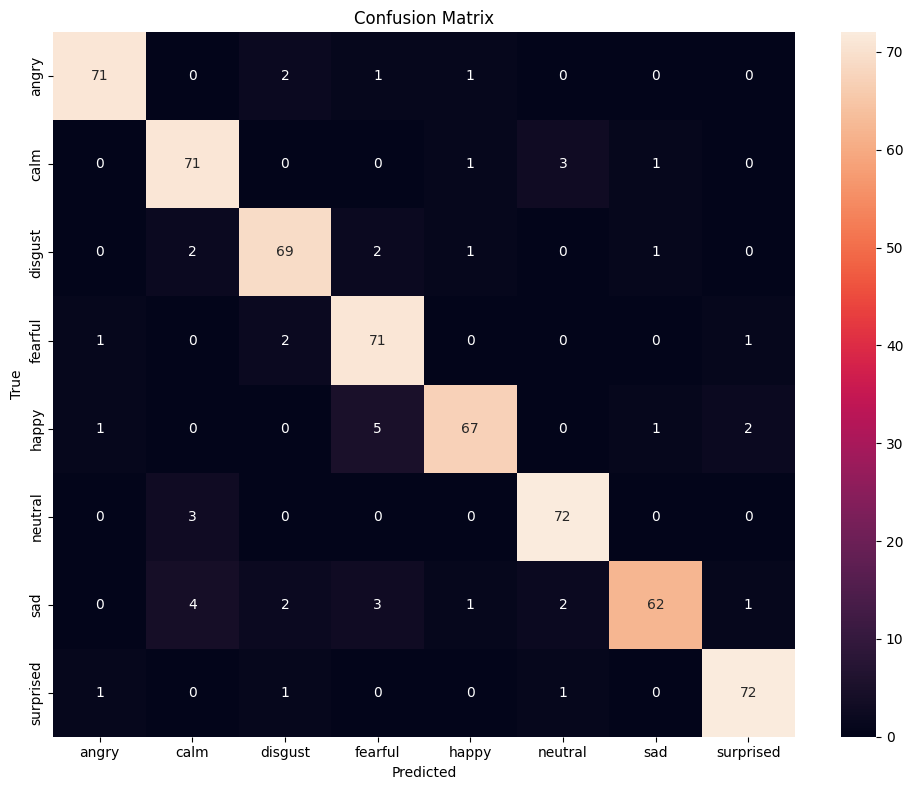

In [ ]:
# analysis 

model = load_model("trained4_model.h5")

y_pred = model.predict(X_val_scaled)
y_val_labels = np.argmax(y_val, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

print("\n Classification Report:")
print(classification_report(y_val_labels, y_pred_labels, target_names=le.classes_))


# emotion wise accuracy
print("\n Emotion-wise Accuracy:")
for i, emotion in enumerate(le.classes_):
    idx = y_val_labels == i
    acc = accuracy_score(y_val_labels[idx], y_pred_labels[idx])
    status = "✅" if acc >= 0.75 else "❌"
    print(f"{status} {emotion}: {acc:.2%} accuracy")


# actor wise accuracy
print("\n Per-Actor Accuracy:")
actor_accuracy = defaultdict(lambda: [0, 0])
for i in range(len(y_val_labels)):
    actor = actors_val[i]
    correct = int(y_val_labels[i] == y_pred_labels[i])
    actor_accuracy[actor][0] += correct
    actor_accuracy[actor][1] += 1

for actor, (correct, total) in sorted(actor_accuracy.items()):
    acc = correct / total if total > 0 else 0
    status = "✅" if acc >= 0.75 else "❌"
    print(f"{status} {actor}: {acc:.2%} accuracy")

overall_acc = accuracy_score(y_val_labels, y_pred_labels)
macro_f1 = f1_score(y_val_labels, y_pred_labels, average='macro')
print(f"\n Overall Accuracy: {overall_acc:.2%}")
print(f" Macro F1 Score: {macro_f1:.2%}")


# confusion matrix 
cm = confusion_matrix(y_val_labels, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("confusion_matrix.png")

